# Ensemble Mean
### Erica Simon, 02/20/24
## Purpose: calculate and visualize ensemble mean of temperature outcomes as generated by 3 different IAM emission trajectories
- calculates avg. temperature outcome for each config
- generates one distribution of 841 configs, rather than 3 x 841
- allows for more concise visualizations

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import pandas as pd

## Globals

In [11]:
weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

In [12]:
scenario_order = ["Net Zero 2050", "Low demand", "Below 2 C", "Delayed transition", 
                  "Fragmented World", "NDCs", "Current Policies"]

In [13]:
NGFS_colors = {
    "Net Zero 2050": "#00a9cf",
    "Below 2 C": "#003466",
    "NDCs": "#f69320",
    "Current Policies": "#df0000",
    "Low demand": "#2274ae",
    "Fragmented World": "#b0724e",
    "Delayed transition": "#92397a",
}

## Get datasets

In [38]:
# open temperature datasets
GCAM_ds = xr.open_dataset('~/outputs/GCAM_prob_run.nc')
MSG_ds = xr.open_dataset('~/outputs/MSG_prob_run.nc')
REM_ds = xr.open_dataset('~/outputs/REM_prob_run.nc')

In [46]:
# remove layer 1 and 2, only layer 0 is relevant for surface temps
GCAM_ds = GCAM_ds.where(GCAM_ds.layer==0, drop=True)
MSG_ds = MSG_ds.where(MSG_ds.layer==0, drop=True)
REM_ds = REM_ds.where(REM_ds.layer==0, drop=True)

## Calculate mean for each config

In [47]:
mean_temps = (GCAM_ds.temperature.values + MSG_ds.temperature.values + REM_ds.temperature.values) / 3

ens_mean = GCAM_ds.copy()

ens_mean.temperature.values = mean_temps

In [48]:
ens_mean

<xarray.Dataset>
Dimensions:      (timebounds: 352, scenario: 7, config: 841, layer: 1)
Coordinates:
  * timebounds   (timebounds) float64 1.75e+03 1.751e+03 ... 2.1e+03 2.101e+03
  * scenario     (scenario) object 'Below 2 C' ... 'Net Zero 2050'
  * config       (config) int64 1234 2451 5859 5883 ... 1592589 1594247 1597937
  * layer        (layer) int64 0
Data variables:
    temperature  (timebounds, scenario, config, layer) float64 0.0 0.0 ... 2.224

## Visualize

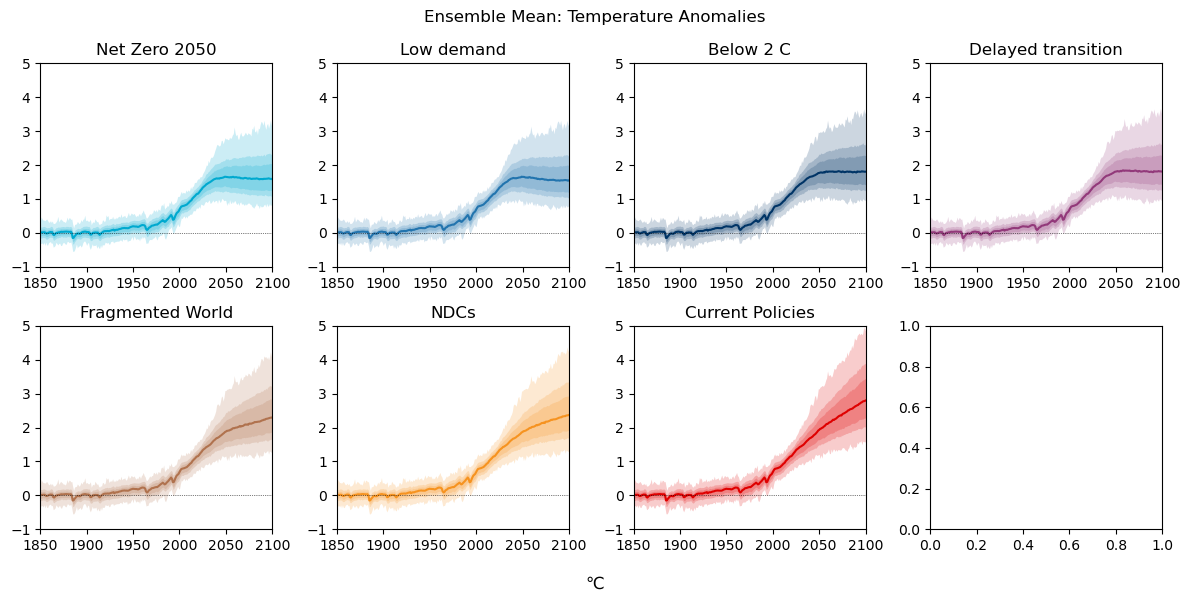

In [85]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenario_order):
    for pp in ((0, 100), (5, 95), (16, 84)):
        ax[i // 4, i % 4].fill_between(
            ens_mean.timebounds,
            np.percentile(
                ens_mean.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    ens_mean.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                pp[0],
                axis=1,
            ),
            np.percentile(
                ens_mean.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    ens_mean.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                pp[1],
                axis=1,
            ),
            color=NGFS_colors[scenario],
            alpha=0.2,
            lw=0
        )

    ax[i // 4, i % 4].plot(
        ens_mean.timebounds,
        np.median(
            ens_mean.temperature.loc[dict(scenario=scenario, layer=0)]
            - np.average(
                ens_mean.temperature.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ],
                weights=weights_51yr,
                axis=0
            ),
            axis=1,
        ),
        color=NGFS_colors[scenario],
    )
    ax[i // 4, i % 4].set_xlim(1850, 2100)
    ax[i // 4, i % 4].set_ylim(-1, 5)
    ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].set_title(scenario)

plt.suptitle('Ensemble Mean: Temperature Anomalies')
fig.supxlabel('℃')
fig.tight_layout()

In [86]:
def plt_temp_distribs(xr, year, xmax=5, ymax=1.4):

    fig, ax = plt.subplots(2, 4, figsize=(12, 6))

    for i, scenario in enumerate(scenario_order):
        r, c = divmod(i, 4)
        
        temp_anom = xr.temperature.loc[dict(scenario=scenario, layer=0, timebounds=year)]- np.average(
                        xr.temperature.loc[
                            dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    )

        sns.kdeplot(temp_anom, ax=ax[r,c], color=NGFS_colors[scenario], fill=True, alpha=0.5)
        ax[r,c].set_title(scenario)
        ax[r,c].set_xlim(0, xmax)
        ax[r,c].set_ylim(0, ymax)

    plt.suptitle("Distribution of Temperature Anomalies in " + str(year) + '\nEnsemble Mean')
    fig.supxlabel('℃')
    fig.tight_layout()

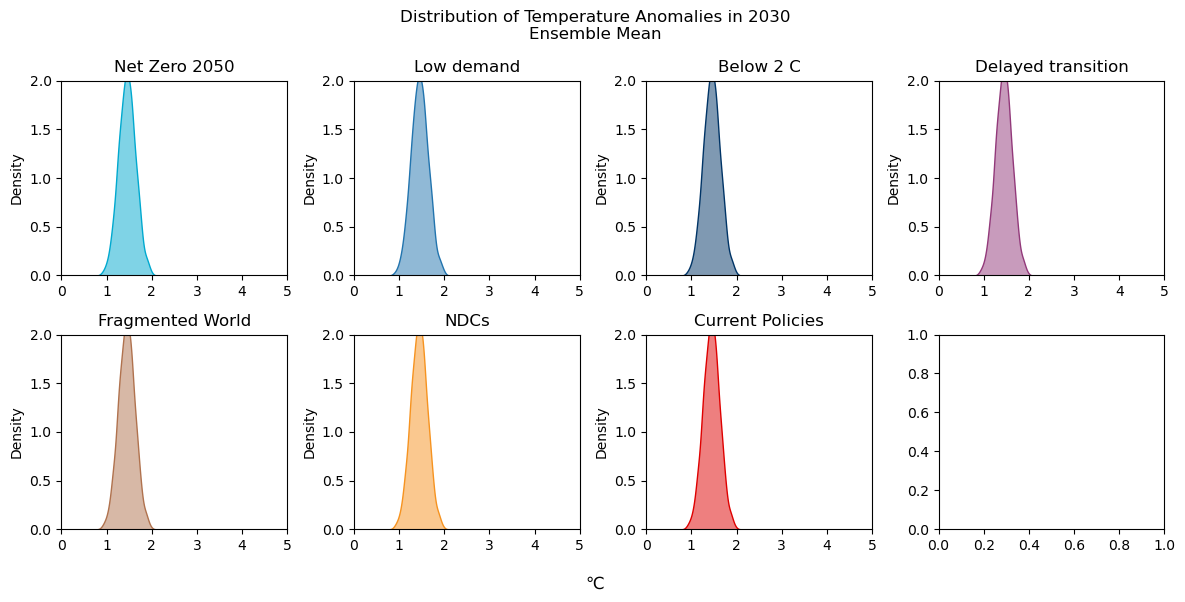

In [87]:
plt_temp_distribs(ens_mean, 2030, ymax=2)

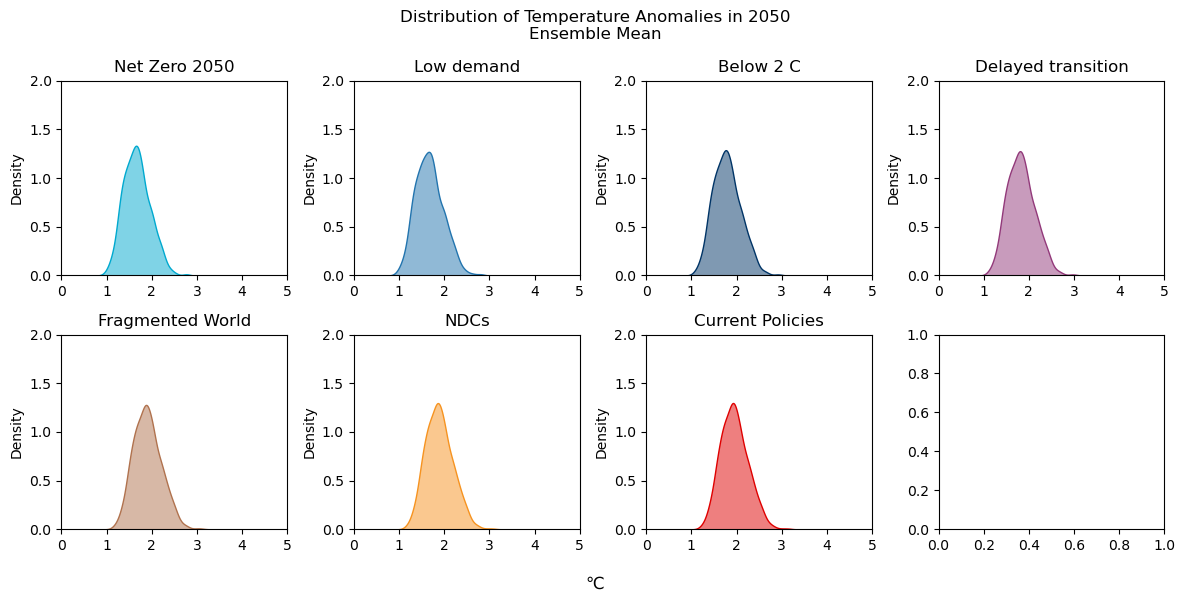

In [88]:
plt_temp_distribs(ens_mean, 2050, ymax=2)

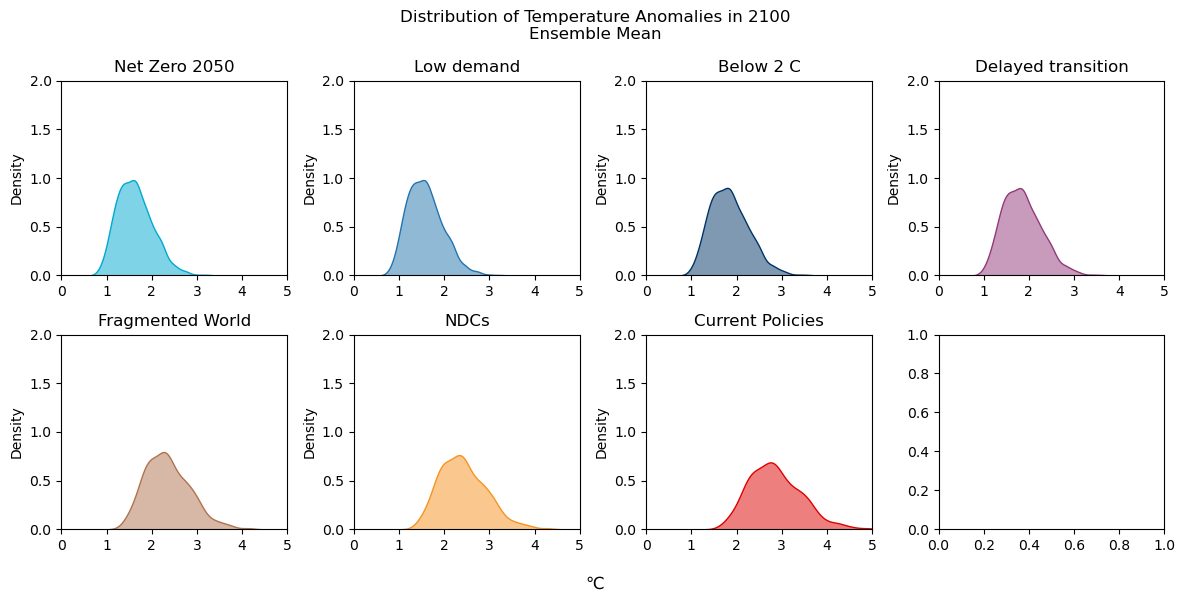

In [89]:
plt_temp_distribs(ens_mean, 2100, ymax=2)

### Percentile Analysis

In [ ]:
def get_percentile(xr, year, lower_perc, upper_perc):
    
    perc_dict = {}

    for scenario in scenario_order:
        
        temp_anom = xr.temperature.loc[dict(scenario=scenario, layer=0, timebounds=year)]- np.average(
                        xr.temperature.loc[
                            dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    )
        
        a = round(np.percentile(temp_anom, lower_perc), 2)
        b = round(np.percentile(temp_anom, upper_perc), 2)
        
        perc_dict[scenario] = [a, b]
    
    return perc_dict

In [94]:
get_percentile(ens_mean, 2100, 95, 100)

{'Net Zero 2050': [2.29, 3.25],
 'Low demand': [2.24, 3.25],
 'Below 2 C': [2.57, 3.59],
 'Delayed transition': [2.59, 3.61],
 'Fragmented World': [3.22, 4.2],
 'NDCs': [3.33, 4.34],
 'Current Policies': [3.87, 4.95]}

In [90]:
def plt_temp_kde_tail(xr, year, lower_perc, upper_perc=100, xmin=2, xmax=5.3, ymax=0.3):

    fig, ax = plt.subplots(2, 4, figsize=(12, 6))

    for i, scenario in enumerate(scenario_order):
        r, c = divmod(i, 4)
        
        temp_anom = xr.temperature.loc[dict(scenario=scenario, layer=0, timebounds=year)]- np.average(
                        xr.temperature.loc[
                            dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    )
        
        a = np.percentile(temp_anom, lower_perc)
        b = np.percentile(temp_anom, upper_perc)

        sns.kdeplot(temp_anom, ax=ax[r,c], color=NGFS_colors[scenario], fill=True, alpha=0.5, clip=(a,b))
        ax[r,c].set_title(scenario)
        ax[r,c].set_xlim(xmin, xmax)
        ax[r,c].set_ylim(0, ymax)
        # ax[r,c].axvline(a, color="k", ls=":", lw=0.5)

    plt.suptitle(str(lower_perc) + "th percentile of Temperature Anomalies in " + str(year) + '\nEnsemble Mean')
    fig.supxlabel('℃')
    fig.tight_layout()

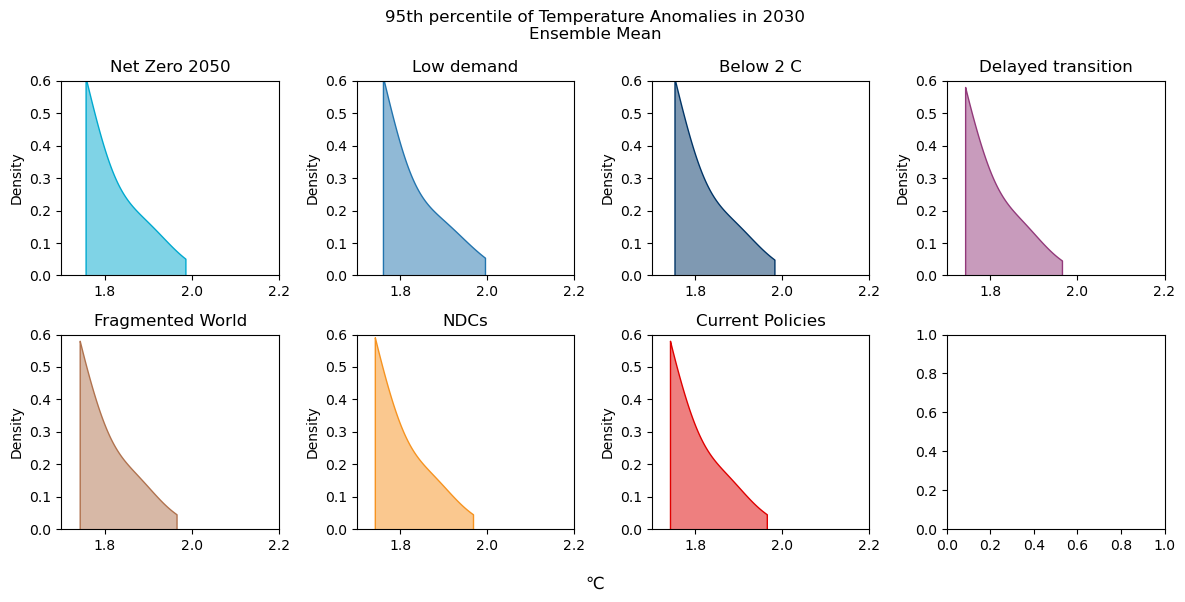

In [91]:
plt_temp_kde_tail(ens_mean, 2030, 95, xmin=1.7, xmax=2.2, ymax=0.6)

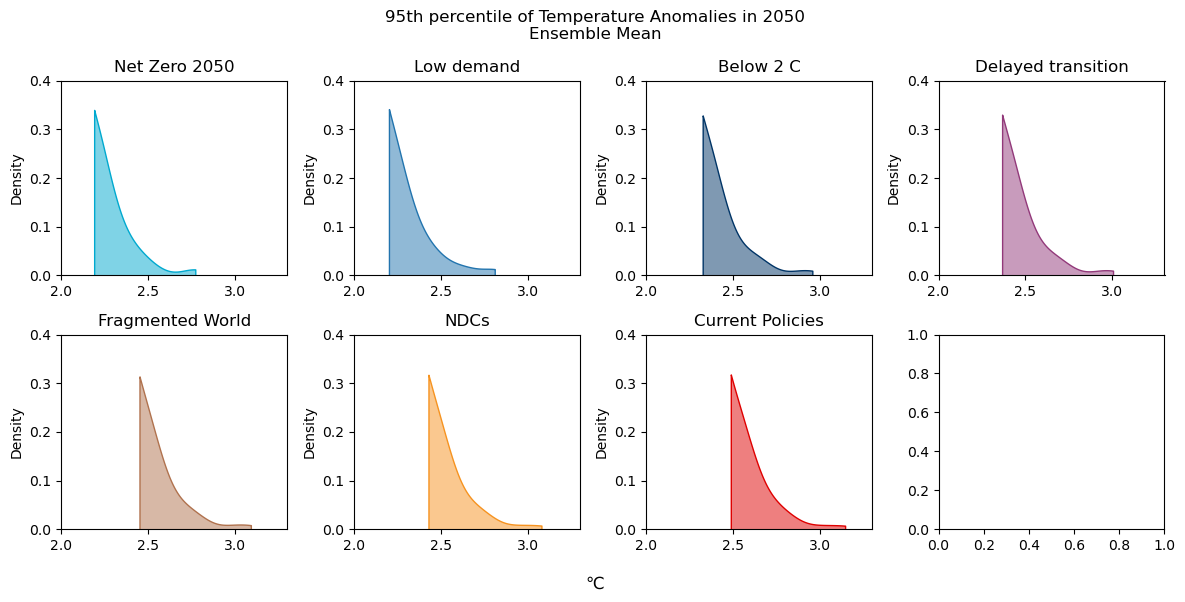

In [92]:
plt_temp_kde_tail(ens_mean, 2050, 95, xmin=2, xmax=3.3, ymax=0.4)

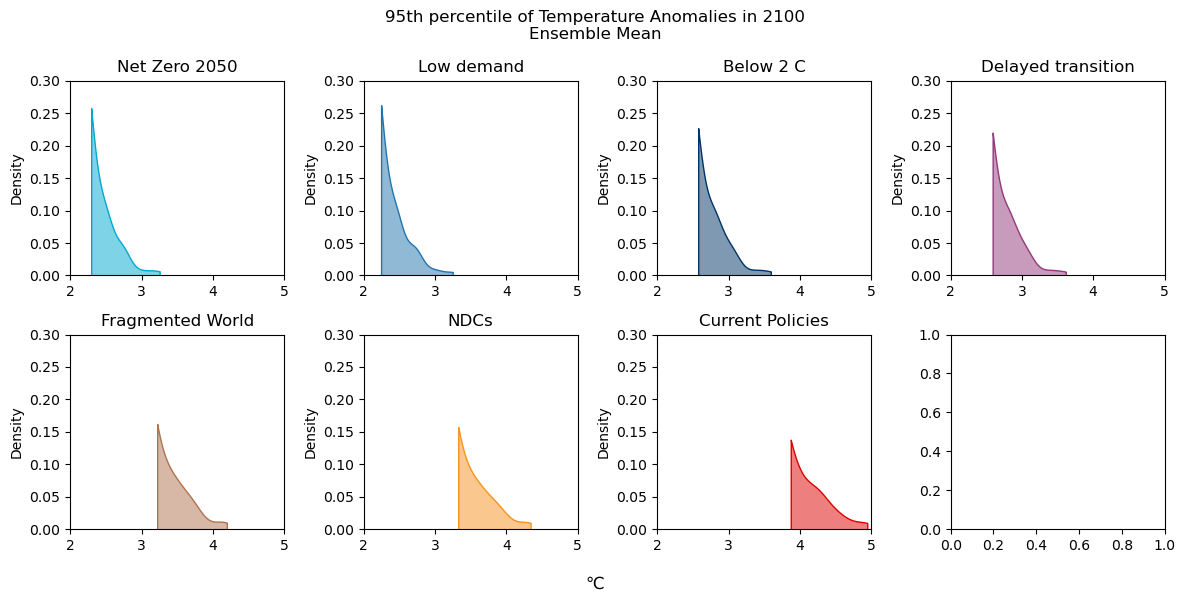

In [93]:
plt_temp_kde_tail(ens_mean, 2100, 95, xmax=5)